In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Class Balancing for Masks



In [11]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import rasterio

from tqdm import tqdm
from config import interim_data_dir, processed_data_dir

from src.utils import read_shapefile, mask_raster, safe_create_dir


### Show class distribution

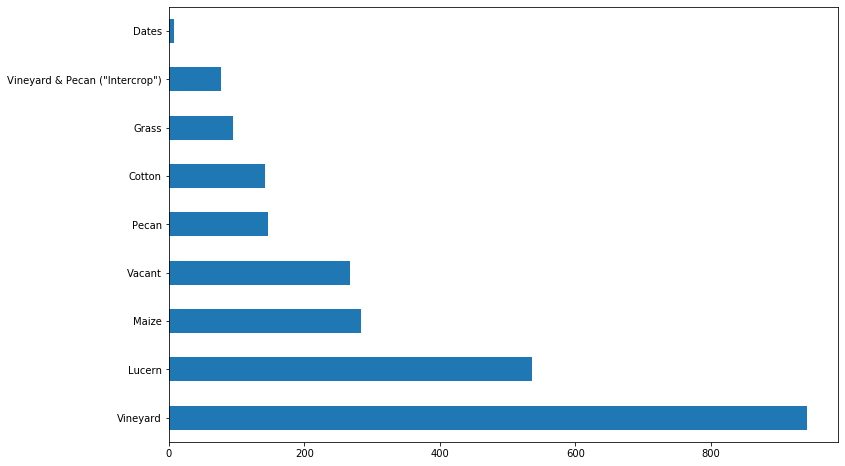

In [12]:
shp_train = read_shapefile('train')

shp_train.y.value_counts().plot.barh(figsize=(12,8))

In [13]:
shp_train.y.value_counts()

Vineyard                          941
Lucern                            536
Maize                             283
Vacant                            267
Pecan                             146
Cotton                            142
Grass                              95
Vineyard & Pecan ("Intercrop")     77
Dates                               7
Name: y, dtype: int64

In [14]:
N_max = 100

n_to_copy = {y: max(0,N_max - n) for y,n in shp_train.y.value_counts().to_dict().items()}
n_to_copy

{'Vineyard': 0,
 'Lucern': 0,
 'Maize': 0,
 'Vacant': 0,
 'Pecan': 0,
 'Cotton': 0,
 'Grass': 5,
 'Vineyard & Pecan ("Intercrop")': 23,
 'Dates': 93}

## Undo previous upsampling

In [15]:
data_dir = interim_data_dir / 'masks_resampled_balanced' / 'train'

for d in tqdm(data_dir.glob('*'), desc='removing copies'):
    if len(str(d.stem).split('_')) > 1:
        rmtree(d)

removing copies: 4277it [00:24, 172.62it/s]


In [16]:
from shutil import copytree, rmtree
from tqdm import tqdm

resampled_dfs = []
for label, N in n_to_copy.items():
    
    label_df = shp_train.loc[shp_train.y == label]
    
    if N == 0:
        resampled_dfs.append(label_df)
        continue

    resampled_df = label_df.sample(N, replace=True, random_state=2019)

    # Get the number of times to copy a certain ID
    ids_to_copy_counts = resampled_df.reset_index().Field_Id.value_counts().to_dict()

    # Generate new ids
    new_ids = [f'{id}_{k}' for id, count in ids_to_copy_counts.items() for k in range(count)]

    # Update the index with the new ids
    resampled_df = resampled_df.sort_index()
    resampled_df.index = pd.Series(sorted(new_ids), name='Field_Id')
    
    resampled_dfs.append(resampled_df)
    
    # Create copy and save as as new ID 
    for ID in tqdm(new_ids, desc=label):
        real_id = ID.split('_')[0]

        id_dir = data_dir / real_id
        new_id_dir = data_dir / ID

        if not new_id_dir.is_dir():
            # Make copy
            copytree(id_dir, new_id_dir)


Dates: 100%|██████████| 93/93 [00:03<00:00, 29.16it/s]


In [17]:
shp_data_out_dir = processed_data_dir / 'shp_resampled' / 'train'
safe_create_dir(shp_data_out_dir)

shp_df_resampled = pd.concat(resampled_dfs, axis=0)

shp_df_resampled.reset_index().to_file(shp_data_out_dir)